# Quantum-enhanced Support Vector Machine (QSVM)

Classification algorithms and methods for machine learning are essential for pattern recognition and data mining applications. Well known techniques such as support vector machines and neural networks have blossomed over the last two decades as a result of the spectacular advances in classical hardware computational capabilities and speed. This progress in computer power made it possible to apply techniques, that were theoretically developed towards the middle of the 20th century, on classification problems that were becoming increasingly challenging.

A key concept in classification methods is that of a kernel. Data cannot typically be separated by a hyperplane in its original space. A common technique used to find such a hyperplane consists of applying a non-linear transformation function to the data. This function is called a feature map, as it transforms the raw features, or measurable properties, of the phenomenon or subject under study. Classifying in this new feature space -and, as a matter of fact, also in any other space, including the raw original one- is nothing more than seeing how close data points are to each other. This is the same as computing the inner product for each pair of data points in the set. So, in fact we do not need to compute the non-linear feature map for each datum, but only the inner product of each pair of data points in the new feature space. This collection of inner products is called the kernel and it is perfectly possible to have feature maps that are hard to compute but whose kernels are not.

In this notebook we provide an example of a classification problem that requires a feature map for which computing the kernel is not efficient classically -this means that the required computational resources are expected to scale exponentially with the size of the problem. We show how this can be solved in a quantum processor by a direct estimation of the kernel in the feature space. The method we used falls in the category of what is called supervised learning, consisting of a training phase (where the kernel is calculated and the support vectors obtained) and a test or classification phase (where new unlabeled data is classified according to the solution found in the training phase).

References and additional details:

[1] Vojtech Havlicek, Antonio D. C´orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, "Supervised learning with quantum enhanced feature spaces," [arXiv: 1804.11326](https://arxiv.org/pdf/1804.11326.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals, MissingOptionalLibraryError
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.ml.datasets import wine, iris, breast_cancer
from qiskit.aqua.utils.dataset_helper import get_feature_dimension
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

import cvxpy 
from sklearn.datasets import load_iris, load_diabetes, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


seed = 10599
aqua_globals.random_seed = seed

# MotorTrend Cars dataset  

The MotorTrend Cars 2004 dataset is used to show how to load classical data from a csv into a format that is digestable for a quantum computer. The qSVM separates SUVs, sedans, and sports cars.  
  
The general approach is as follows:  
1. Import csv data and create labels and target variable  
2. Standardize/Normalize data so all values are on the same scale  
3. Perform PCA to reduce number of columns using Principle Components Analysis dimenionality reduction to reduce the amount if columns to send to the quantum system while preserving useful information from the compressed variables. 
4. Create pairs of points and attach target labels to data dictionary prior to running qSVM
5. Run QSVM to create hyperplane separating the three classes of data (SUV, Sedan, Sports) vehicle classes

In [140]:
n=5
class_labels = [r'SUV', r'Sedan', r'Sports']
training_size = 0.3

os.getcwd()
#os.listdir()

cars = pd.read_csv('https://github.com/danielcbeaulieu/quantum/raw/main/CARS_2004.csv')
cars.head()

,Make,Model,Type,Origin,DriveTrain,MSRP,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
0,Acura,MDX,SUV,Asia,All,36945,33337,3.5,6.0,265,17,23,4451,106,189
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,23820,21761,2.0,4.0,200,24,31,2778,101,172
2,Acura,TSX 4dr,Sedan,Asia,Front,26990,24647,2.4,4.0,200,22,29,3230,105,183
3,Acura,TL 4dr,Sedan,Asia,Front,33195,30299,3.2,6.0,270,20,28,3575,108,186
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,43755,39014,3.5,6.0,225,18,24,3880,115,197


With the dataset ready we can setup the [QSVM](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.QSVM.html) algorithm to do a classification. Here we use the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) data encoding circuit from the Qiskit circuit library.

Here the BasicAer `qasm_simulator` is used with 1024 shots.

For the testing, the result includes the details and the success ratio. For the prediction, the result includes the predicted labels. 

In [138]:
pd.crosstab(cars.Type.values, cars.Origin.values)
#cars_svm_dum.head()

col_0,Asia,Europe,USA
row_0,,,
Hybrid,3,0,0
SUV,25,10,25
Sedan,94,78,90
Sports,17,23,9
Truck,8,0,16
Wagon,11,12,7


In [142]:
cars2 = cars
cars3 = cars2[((cars2['Type'] == 'SUV') & (cars2['Origin'] == 'USA')) | ((cars2['Type'] == 'Sports') & (cars2['Origin'] == 'Europe')) | ((cars2['Type'] == 'Sedan') & (cars2['Origin'] == 'Europe') & (cars2['MSRP'] < 40000))]

cars_svm_dum = pd.get_dummies(cars3)

# create a list of our conditions
conditions = [
    (cars_svm_dum['Type_SUV'] == 1),
    (cars_svm_dum['Type_Sedan'] == 1),
    (cars_svm_dum['Type_Sports'] == 1)
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
cars_svm_dum['targ'] = np.select(conditions, values)

cars_notarg = cars_svm_dum[['EngineSize', 'Length', 'MSRP', 'MPG_City', 'Wheelbase', 'Horsepower', 'Weight', 'MPG_Highway', 'Origin_Europe', 'Origin_USA', 'DriveTrain_All', 'DriveTrain_Front', 'DriveTrain_Rear']]
cars_svm2 = cars_svm_dum[['EngineSize', 'Length', 'MSRP', 'MPG_City', 'Wheelbase', 'Horsepower', 'Weight', 'MPG_Highway', 'Origin_Europe', 'Origin_USA', 'DriveTrain_All', 'DriveTrain_Front', 'DriveTrain_Rear', 'targ']]

cars_targ = np.asarray(cars_svm2['targ'], dtype=int)
sample_train, sample_test, label_train, label_test = \
    train_test_split(cars_notarg, cars_targ, test_size=0.3, random_state=7)

# Now we standarize for gaussian around 0 with unit variance
std_scale = StandardScaler().fit(sample_train)
sample_train_tran = std_scale.transform(sample_train)
sample_test_tran = std_scale.transform(sample_test)

# Now reduce number of features to number of qubits
pca = PCA(n_components=n).fit(sample_train_tran)
sample_train_tran = pca.transform(sample_train_tran)
sample_test_tran = pca.transform(sample_test_tran)

# Samples are pairs of points
samples = np.append(sample_train_tran, sample_test_tran, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train_fin = minmax_scale.transform(sample_train_tran)
sample_test_fin = minmax_scale.transform(sample_test_tran)

train_num_rows, train_num_cols = sample_train_fin.shape 
test_num_rows, test_num_cols = sample_test_fin.shape 

training_input = {key: (sample_train_fin[label_train == k, :])[:train_num_rows]
                 for k, key in enumerate(class_labels)}
test_input = {key: (sample_test_fin[label_test == k, :])[:test_num_rows]
              for k, key in enumerate(class_labels)}

In [144]:
temp = [test_input[k] for k in test_input]
total_array = np.concatenate(temp)

In [145]:
aqua_globals.random_seed = 10598

backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(training_input),
                           reps=2, entanglement='linear')
svm = QSVM(feature_map, training_input, test_input, total_array,
           multiclass_extension=AllPairs())
quantum_instance = QuantumInstance(backend, shots=1024,
                                   seed_simulator=aqua_globals.random_seed,
                                   seed_transpiler=aqua_globals.random_seed)

result = svm.run(quantum_instance)
for k,v in result.items():
    print(f'{k} : {v}')

testing_accuracy : 0.8928571428571429
test_success_ratio : 0.8928571428571429
predicted_labels : [0 0 0 0 0 0 1 1 1 1 2 1 1 1 1 1 0 1 1 1 1 1 1 2 2 2 2 0]
predicted_classes : ['SUV', 'SUV', 'SUV', 'SUV', 'SUV', 'SUV', 'Sedan', 'Sedan', 'Sedan', 'Sedan', 'Sports', 'Sedan', 'Sedan', 'Sedan', 'Sedan', 'Sedan', 'SUV', 'Sedan', 'Sedan', 'Sedan', 'Sedan', 'Sedan', 'Sedan', 'Sports', 'Sports', 'Sports', 'Sports', 'SUV']


As you can see, we get 89% accuracy after using PCA to redudce the dimensions to where a quantum computer can accept the size of the classical data we get an estimation that is similar to conventional SVMS. Qiskit also has a classical SVM implementation that takes the same input data for classification. Let's run this and do a comparison. Now the ad hoc data set was created to show that there can be datasets where quantum could give an advantage.

In [126]:
result = SklearnSVM(training_input, test_input, multiclass_extension=AllPairs()).run()

print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.8928571428571429


## Wine Classification Dataset

We want a dataset with more than two classes, so here we choose the Wine dataset that has 3 classes.

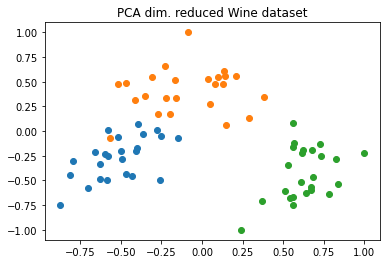

In [132]:
from qiskit.ml.datasets import wine

n = 2  # dimension of each data point
sample_Total, training_input, test_input, class_labels = wine(training_size=24,
                                                              test_size=6, n=n, plot_data=True)
temp = [test_input[k] for k in test_input]
total_array = np.concatenate(temp)

To used a multiclass extension an instance thereof simply needs to be supplied, on the QSVM creation, using the multiclass_extension parameter. Although AllPairs() is used in the example below, the following multiclass extensions would also work:

OneAgainstRest()

ErrorCorrectingCode(code_size=5)

In [133]:
aqua_globals.random_seed = 10598

backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(training_input),
                           reps=2, entanglement='linear')
svm = QSVM(feature_map, training_input, test_input, total_array,
           multiclass_extension=AllPairs())
quantum_instance = QuantumInstance(backend, shots=1024,
                                   seed_simulator=aqua_globals.random_seed,
                                   seed_transpiler=aqua_globals.random_seed)

result = svm.run(quantum_instance)
for k,v in result.items():
    print(f'{k} : {v}')

testing_accuracy : 1.0
test_success_ratio : 1.0
predicted_labels : [0 1 2 2 2 2]
predicted_classes : ['A', 'B', 'C', 'C', 'C', 'C']
